In [1]:
%run ../supportvectors-common.ipynb


<div style="color:#aaa;font-size:8pt">
<hr/>
&copy; SupportVectors. All rights reserved. <blockquote>This notebook is the intellectual property of SupportVectors, and part of its training material. 
Only the participants in SupportVectors workshops are allowed to study the notebooks for educational purposes currently, but is prohibited from copying or using it for any other purposes without written permission.

<b> These notebooks are chapters and sections from Asif Qamar's textbook that he is writing on Data Science. So we request you to not circulate the material to others.</b>
 </blockquote>
 <hr/>
</div>



We walk through a VQVAE AutoEncoder on the MNIST dataset

First the imports

In [2]:

import torch
from torch.utils.data import DataLoader
from svlearn.auto_encoders.vqvae_auto_encoder_mnist import VqvaeAutoencoderMnist
import torchvision.datasets as datasets
from svlearn.auto_encoders.auto_encoder_util import visualize_interpolations

Load the path for mnist data and results

In [3]:
mnist_data_path = '/home/chandar/data'
model_path = '/home/chandar/results'

In [4]:
mnist_trainset = datasets.MNIST(root=mnist_data_path, train=True, download=True, transform=None)

train_dataset = mnist_trainset.data[:-10000].reshape(-1, 1, 28, 28) / 255.
eval_dataset = mnist_trainset.data[-10000:].reshape(-1, 1, 28, 28) / 255.

In [5]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(eval_dataset, batch_size=128, shuffle=False)

Identify device (either cuda or cpu)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = VqvaeAutoencoderMnist().to(device)

In [7]:
checkpoint = torch.load(f"{model_path}/mnist/mnist_vqvae_autoencoder.pt")
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

VqvaeAutoencoderMnist(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(512, 16, kernel_size=(1, 1), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(16, 512, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(12

Visualize the reconstruction (top row being original images and bottom being reconstructed)

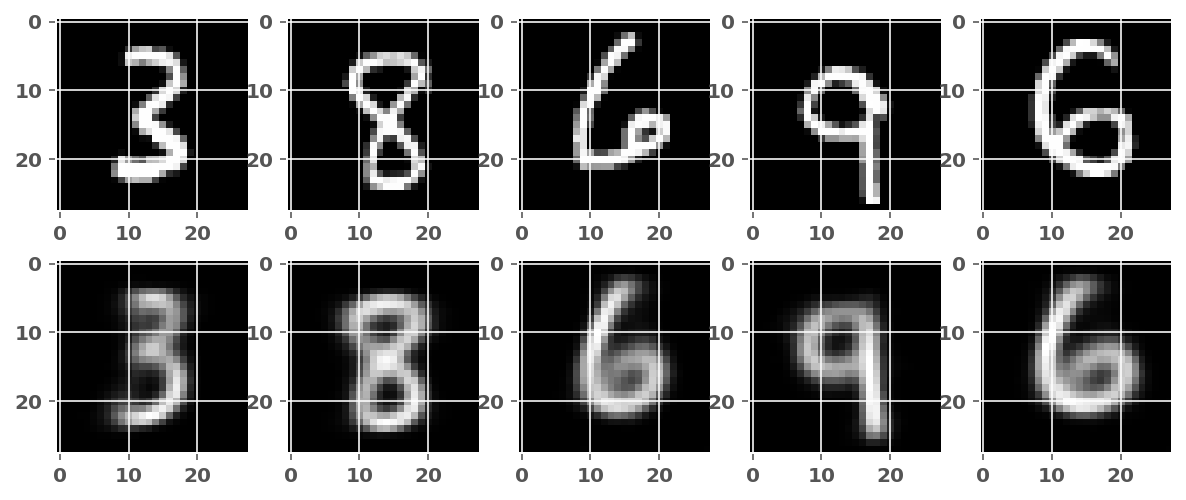

In [8]:
import matplotlib.pyplot as plt
model.eval()
with torch.no_grad():
    images = next(iter(val_loader))
    images = [img.to(device) for img in images]
    images = torch.stack(images)
    reconstructed, _, _, _, _ = model(images)
    
    # Display original and reconstructed images
    _, axs = plt.subplots(2, 5, figsize=(10, 4))
    for i in range(5):
        axs[0, i].imshow(images[i].cpu().squeeze(0), cmap='gray')
        axs[1, i].imshow(reconstructed[i].cpu().squeeze(0), cmap='gray')
    plt.show()

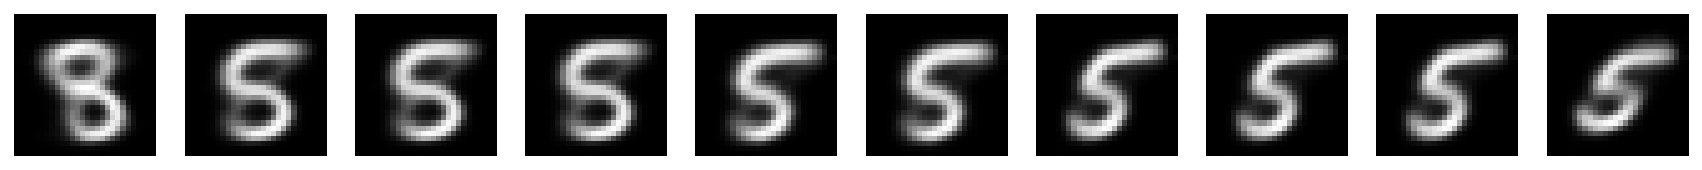

In [14]:
# Create random shuffle of train dataset to pick random 2 images every time.
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
first_train_batch = next(iter(train_loader))
# Visualize interpolations
# Assuming image1 and image2 are samples from your dataset (PIL images already transformed to tensor)
image1 = first_train_batch[0]  # First image
image2 = first_train_batch[1]  # Second image

# Visualize interpolation between the two images
visualize_interpolations(model, image1, image2, num_steps=10, device=device)

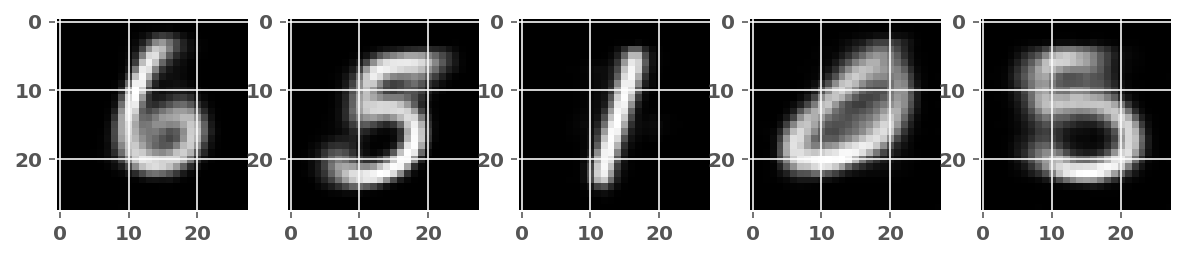

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from svlearn.auto_encoders.auto_encoder_util import convert

codebook_usage_per_position = np.load(f"{model_path}/mnist/vqvae_codebook_usage.npy")

codebook_probabilities_per_position = codebook_usage_per_position / (codebook_usage_per_position.sum(axis=-1, keepdims=True))
total_usage_per_position = codebook_usage_per_position.sum(axis=-1)

latent_grid_size = (1, 1)
generator = np.random.default_rng()

# Number of images to generate
num_images = 5

# Sample codebook indices for the latent grid size (1X1) for all images at once
random_latent_indices = np.zeros((num_images, *latent_grid_size), dtype=int)

# Generate random latent indices for each position in the 1X1 grid based on learned probabilities
for i in range(latent_grid_size[0]):
    for j in range(latent_grid_size[1]):
        if total_usage_per_position[i,j] == 0:
            print(f"No usage at {i},{j}")
            continue
        random_latent_indices[:, i, j] = generator.choice(
            np.arange(128), 
            size=num_images,  # Sample 5 indices at once for each position
            p=codebook_probabilities_per_position[i, j]
        )


# Retrieve the corresponding codebook vectors for the sampled indices
random_latent_vectors = model.vq_embedding.embedding.weight[random_latent_indices]
# random_latent_vectors will have shape (5, 1, 1, embedding_dim)
# therefore permute to have channels at position 1
random_latent_vectors = random_latent_vectors.permute(0,3,1,2)


with torch.no_grad():
    generated_images = model.decoder(random_latent_vectors.to(device))
    # Display original and reconstructed images
    _, axs = plt.subplots(1, 5, figsize=(10, 4))
    for i in range(5):
        axs[i].imshow(generated_images[i].cpu().squeeze(0), cmap='gray')
    plt.show()